# Notebook #5: Comparison of DSD response analysed with ML and the literature

In the [2017 article](https://www.tandfonline.com/doi/full/10.1080/00401706.2016.1234979) "Effective Design-Based Model Selection for Definitive Screening Designs",
Jones and Nachtsheim (the authors of DSD) propose a scheme to analyse the response from a Definitive Screening Design.

A data example in 6 factors / 17 runs is presented, in this notebook I compare the fitted model by the author with the standard `LassoLARS` machine learning method I would use. 

Note that factors `D`, `E`, and `F` give no contribute to the response, and are just added for purpose of investigation on sparsity.

Read the [conclusions](##Conclusions) at the end of the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import definitive_screening_design as dsd

# Need for `pip install scikit-learn`.  This library is needed to perform the linear model fit. 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoLars, Lasso, LinearRegression
from sklearn.pipeline import Pipeline

In [2]:
data = "1 0 1 1 1 1 1 15.783 2 0 -1 -1 -1 -1 -1 4.167 3 1 0 1 1 -1 1 43.100 4 -1 0 -1 -1 1 -1 3.633 5 1 -1 0 1 1 -1 17.333 6 -1 1 0 -1 -1 1 4.567 7 1 -1 -1 0 1 1 7.717 8 -1 1 1 0 -1 -1 4.767 9 1 1 -1 -1 0 1 42.800 10 -1 -1 1 1 0 -1 3.983 11 1 -1 1 -1 -1 0 33.367 12 -1 1 -1 1 1 0 4.600 13 1 1 -1 1 -1 -1 42.800 14 -1 -1 1 -1 1 1 3.983 15 1 1 1 -1 1 -1 48.167 16 -1 -1 -1 1 -1 1 2.367 17 0 0 0 0 0 0 13.783".split()
A = (
    pd.DataFrame(
        data = np.array(data).reshape(-1 , 8),
        columns = "Run A B C D E F Time".split()
    )
    .astype({"Run": int, "A": int, "B": int, "C": int, "D": int, "E": int, "F": int, "Time": float})
    .set_index("Run")
)
A

,A,B,C,D,E,F,Time
Run,,,,,,,
1,0,1,1,1,1,1,15.783
2,0,-1,-1,-1,-1,-1,4.167
3,1,0,1,1,-1,1,43.100
4,-1,0,-1,-1,1,-1,3.633
5,1,-1,0,1,1,-1,17.333
6,-1,1,0,-1,-1,1,4.567
7,1,-1,-1,0,1,1,7.717
8,-1,1,1,0,-1,-1,4.767
9,1,1,-1,-1,0,1,42.800


In [3]:
# Results of the fit from the article
df_main = pd.DataFrame(
    data= { 
        "ref_3kF": [11.9, 14.2, 5.7, 4.3, 0, 0,   0, 6.4, 6.2, 4.6, 0, 0, 0, 0, -2.5, 0,0,0,0,0,0,0,0,0,0,0,0,0],
        "ref_DSD": [13.1, 14.8, 6.6, 3.2, 0, 2.4, 0, 5.3, 6.2, 3.2, 0, 0, 0, 0, -2.8, 0,0,0,0,0,0,0,0,0,0,0,0,0]
    },
    index=["(1) A B C D E F AA AB AC AD AE AF BB BC BD BE BF CC CD CE CF DD DE DF EE EF FF".split(" ")]
)

In [4]:
# Store the prediction on the DOE samples (training set)
pred_on_train = {}

In [5]:

X_df = A[list("ABCDEF")]
y_df = A[["Time"]]
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(
        degree=2,
        interaction_only=False,
        include_bias=True
    )),
    ('estimator', LassoLars(
        alpha=1.0,            # Using the default value of scikit-learn: need for hypertuning! 
        normalize=False
    ))
])

pipe.fit(X_df, y_df)
df = pd.DataFrame(
    pipe[-1].coef_.copy().reshape(1,-1), 
    columns=["(1) A B C D E F AA AB AC AD AE AF BB BC BD BE BF CC CD CE CF DD DE DF EE EF FF".split(" ")],
    index=['Fit'],
).T
df.loc["(1)", "Fit"] = pipe[-1].intercept_
label = "ABCDEF_LassoLARS_1.0"
df_main = df_main.join(df).rename(columns={"Fit": label})
pred_on_train[label] = pipe.predict(X_df)

In [6]:
# Excluding the smallest main effects, i.e., D and F, and decreasing Lasso's alpha

for alpha in [1.0, 0.5, 0.1, 0.0]:
    X_df = A[list("ABCE")]
    y_df = A[["Time"]]
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('preprocessor', PolynomialFeatures(
            degree=2,
            interaction_only=False,
            include_bias=True
        )),
        ('estimator', LassoLars(
            alpha=alpha,            # Using the default value of scikit-learn: need for hypertuning! 
            normalize=False
        ))
    ])

    pipe.fit(X_df, y_df)
    df = pd.DataFrame(
        pipe[-1].coef_.copy().reshape(1,-1), 
        columns=["(1) A B C E AA AB AC AE BB BC BE CC CE EE".split(" ")],
        index=['Fit'],
    ).T
    df.loc["(1)", "Fit"] = pipe[-1].intercept_
    label = f"ABCE_LassoLARS_{alpha}"
    df_main = df_main.join(df).rename(columns={"Fit": label})
    pred_on_train[label] = pipe.predict(X_df)

In [7]:
# Using just Lasso (i.e. no LARS)

for alpha in [1.0, 0.5, 0.1]:
    X_df = A[list("ABCE")]
    y_df = A[["Time"]]
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('preprocessor', PolynomialFeatures(
            degree=2,
            interaction_only=False,
            include_bias=True
        )),
        ('estimator', Lasso(
            alpha=alpha,            # Using the default value of scikit-learn: need for hypertuning! 
            # normalize=False DEPRECATED
        ))
    ])

    pipe.fit(X_df, y_df)
    df = pd.DataFrame(
        pipe[-1].coef_.copy().reshape(1,-1), 
        columns=["(1) A B C E AA AB AC AE BB BC BE CC CE EE".split(" ")],
        index=['Fit'],
    ).T
    df.loc["(1)", "Fit"] = pipe[-1].intercept_
    label = f"ABCE_Lasso_{alpha}"
    df_main = df_main.join(df).rename(columns={"Fit": label})
    pred_on_train[label] = pipe.predict(X_df)

In [8]:
# Using pure LinearRegression (i.e., Lasso with alpha=0)

X_df = A[list("ABCE")]
y_df = A[["Time"]]
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(
        degree=2,
        interaction_only=False,
        include_bias=True
    )),
    ('estimator', LinearRegression())
])

pipe.fit(X_df, y_df)
df = pd.DataFrame(
    pipe[-1].coef_.copy().reshape(1,-1), 
    columns=["(1) A B C E AA AB AC AE BB BC BE CC CE EE".split(" ")],
    index=['Fit'],
).T
df.loc["(1)", "Fit"] = pipe[-1].intercept_
label = "ABCE_LinReg"
df_main = df_main.join(df).rename(columns={"Fit": label})
pred_on_train[label] = pipe.predict(X_df)

In [9]:
df_main

,ref_3kF,ref_DSD,ABCDEF_LassoLARS_1.0,ABCE_LassoLARS_1.0,ABCE_LassoLARS_0.5,ABCE_LassoLARS_0.1,ABCE_LassoLARS_0.0,ABCE_Lasso_1.0,ABCE_Lasso_0.5,ABCE_Lasso_0.1,ABCE_LinReg
(1),11.9,13.1,17.465706,17.465706,15.238163,13.691842,13.416212,17.465706,15.236208,13.688123,13.416212
A,14.2,14.8,12.442708,12.442708,12.942708,13.342708,13.442708,12.442708,12.942708,13.342708,13.442708
B,5.7,6.6,4.870587,4.870587,5.370587,5.770587,5.870587,4.870587,5.370587,5.770587,5.870587
C,4.3,3.2,1.921195,1.921195,2.421195,2.821195,2.921195,1.921195,2.421195,2.821195,2.921195
D,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E,0.0,2.4,-1.198642,-1.198642,-1.698642,-2.098642,-2.198642,-1.198642,-1.698642,-2.098642,-2.198642
F,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AA,6.4,5.3,0.000000,0.000000,2.227543,3.773864,4.230982,0.000000,2.229498,3.777583,3.851834
AB,6.2,6.2,2.919940,3.961815,4.505353,5.341901,5.509103,3.961811,4.505091,5.339650,5.212221
AC,4.6,3.2,1.540100,2.044432,2.587587,2.942502,3.009382,2.044447,2.586697,2.941850,3.243230


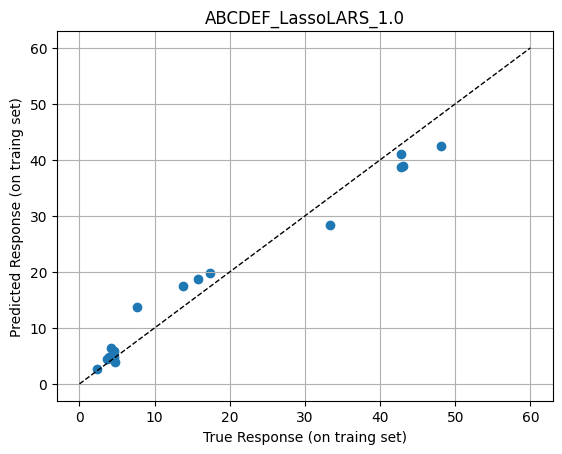

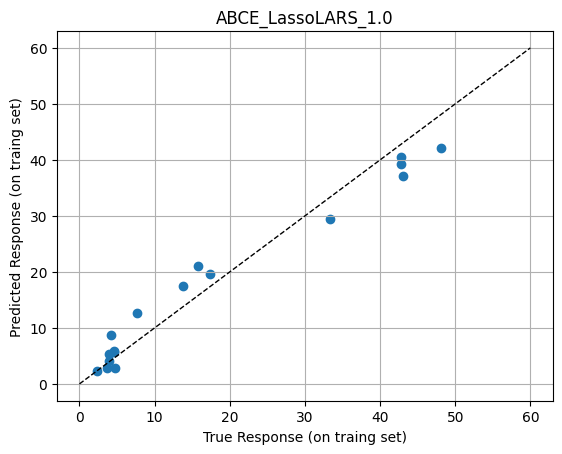

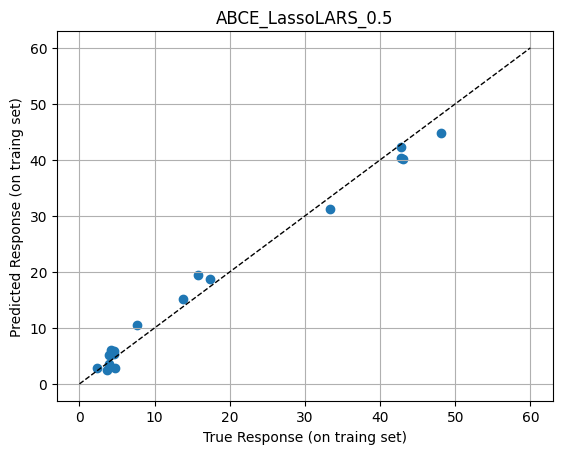

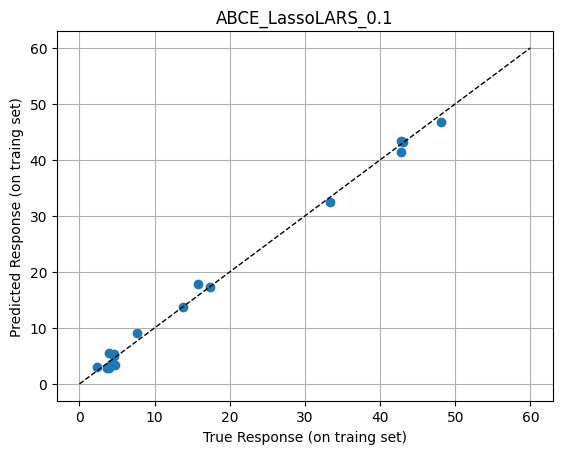

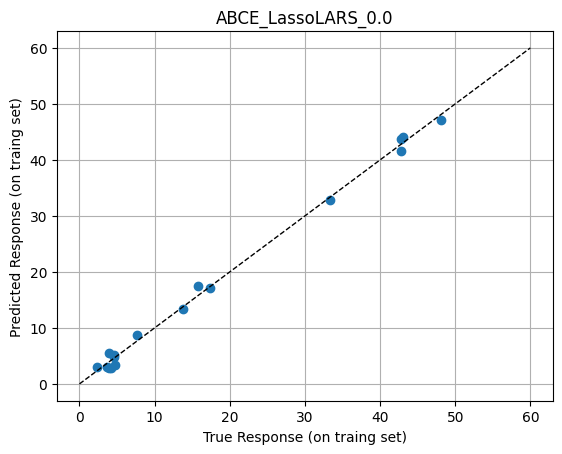

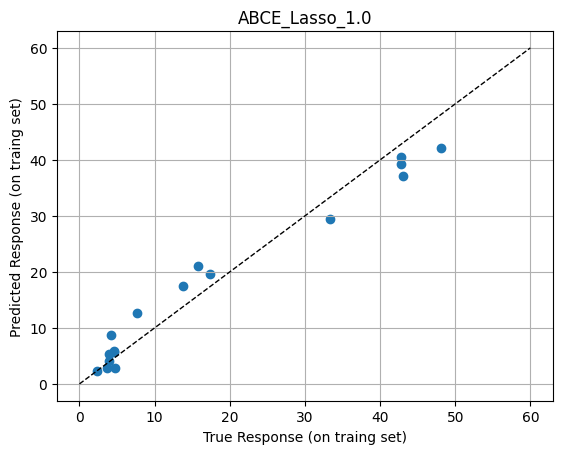

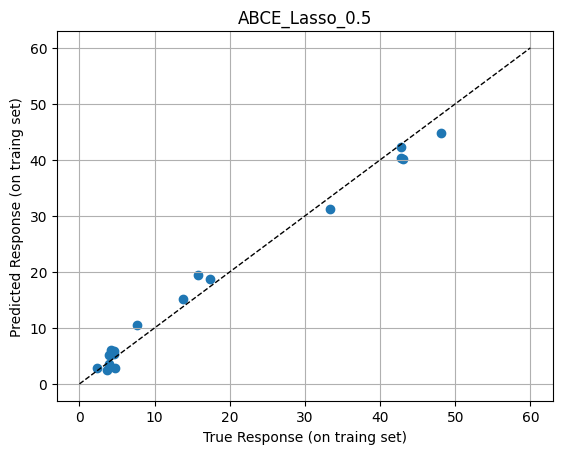

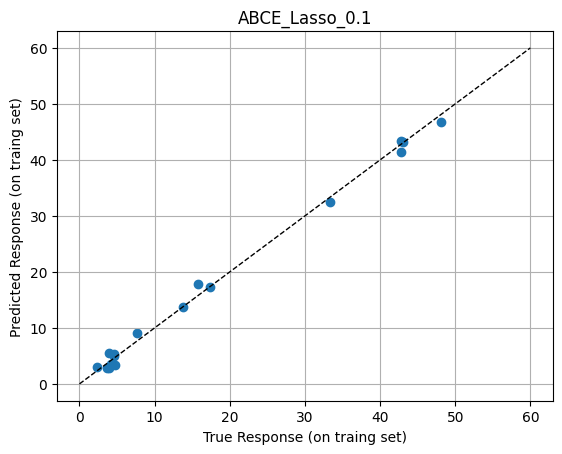

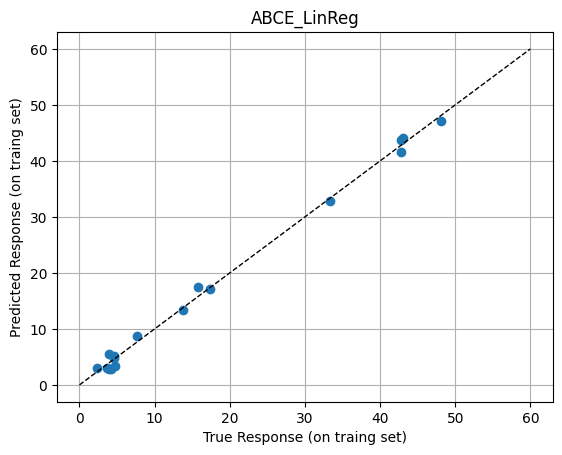

In [10]:

for label, y_pred in pred_on_train.items():
    plt.figure(dpi=100)
    plt.scatter(y_df, y_pred)
    plt.title(label)
    plt.plot([0,60],[0, 60], ls="--", lw=1, c='k')
    plt.xlabel("True Response (on traing set)")
    plt.ylabel("Predicted Response (on traing set)")
    plt.grid()
    plt.show()

## Conclusions
- The Lasso of LassoLARS with `alpha=1.0` is applying too much constraint to find the `AA` effect as in the article
  - only lowering `alpha<0.5` allows to find the `AA` effect as active
  - the match with true response is also better because ther is not the lasso constraint... but it could be overfitting!
  - however, lowering `alpha` more and more also the `AE` and `CE` effects became active
    - therefore, if there are too few data for a data-split validation, it is still much of a user choice to choose a proper `alpha` value
  - we can not exclude that the author, knowing the "true model" tuned the analysis to make it look good, i.e., without `AE` and `CE` terms
- LassoLARS is excluding D and F but it does not have *Principle of Hierarchy* embedded
  - to exclude all D- and F-related terms, the user has to drop them from the dataset before applying `PolynomialFeatures`